# Predictions on the dataset

Based on the first notebook : https://github.com/csho33/bacteria-ID/blob/master/2_reference_prediction.ipynb

## Libraries and imports

Setup the import and the libraries that we'll use along the code

In [3]:
from time import time
t00 = time()
import numpy as np
import os, re, sys
import tensorflow as tf
import torch
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from statistics import mean

## Loading the data

Load the spectra data of ALS and CTRL patients & the Bacteria material (pre-trained model, resnet, ...) for transfer learning

In [4]:
#Load from directory
os.chdir(os.getcwd())
base_dir = 'Raman_Data/'
als_dir = base_dir + 'ALS/'
ctrl_dir = base_dir + 'CTRL/'

base_dir2 = 'Bacteria_TL'
sys.path.append(base_dir2)

models = ['pretrained_model.ckpt', 'finetuned_model.ckpt', 'clinical_pretrained_model.ckpt']

Sort files by ascending order

In [5]:
all_files_als = os.listdir(als_dir)
all_files_als.sort(key=lambda f: int(re.sub('\D', '', f)))
all_files_ctrl = os.listdir(ctrl_dir)
all_files_ctrl.sort(key=lambda f: int(re.sub('\D', '', f)))

### Utility function to parse data files

In [6]:
def parse_text(file, dir):
    with open(dir + file, 'rt') as fd:
        data=[]
        line = fd.readline()
        nline = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        data.append(nline)
        while line:
            line=fd.readline()
            nline = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            data.append(nline)
    return data

### Create X and Y

In [7]:
X=[] #actual y of spectra
Y=[] # 1 -> als; 0 -> ctrl
coord=[] #actual x of spectra

sep=[60,78,114,150,194,210,225,241,255,280,299,313,323,333,343,353,363,373,383,393] #Il manque le 227
groups=[] #for GROUP K FOLD
group=0
index=1
for f in all_files_als:
    data=[]
    datab=[]
    for e in parse_text(f, als_dir):
        if len(e) > 0:
            datab.append(float(e[0]))
            data.append(float(e[1]))
    coord.append(datab)
    X.append(data)
    Y.append(1)
    groups.append(group)
    if index in sep:
        group+=1
    index+=1

In [8]:
#print(len(X))
sep=[33,76,91,138,149,158,168,178,188,198]
index=1
for f in all_files_ctrl:
    data=[]
    datab=[]
    for e in parse_text(f, ctrl_dir):
        if len(e) > 0:
            datab.append(float(e[0]))
            data.append(float(e[1]))
    coord.append(datab)
    X.append(data)
    Y.append(0)
    groups.append(group)
    if index in sep:
        group+=1
    index+=1

In [9]:
X=np.array(X)
Y=np.array(Y)
groups=np.array(groups)
print(X.shape, Y.shape)

(591, 1174) (591,)


### Remove negative values from spectra

In [10]:
for i in range(len(X)):
    for j in range (len(X[i])):
        if(X[i][j] < 0):
            X[i][j] = 0

## PCA : features selection

In [11]:
# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the features and transform
X_std = sc.fit_transform(X)

In [12]:
# Create a pca object with the 2 components as a parameter
pca = decomposition.PCA(n_components=500)

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)
print(X_std_pca.shape)

(591, 500)


## Loading pre-trained CNN

Define the CNN parameters with 1174 as input_dim and 2 as number of output classes (CTRL/ALS)

In [13]:
# CNN parameters
layers = 6
hidden_size = 100
block_size = 2
hidden_sizes = [hidden_size] * layers
num_blocks = [block_size] * layers
input_dim = 1174
in_channels = 64
n_classes = 2 # 2 classes -> 0 : ctrl & 1 : als
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(0)
cuda = torch.cuda.is_available()

This function helps removing the weights on the last layer of the models which are pretrained on 30 output classes

In [14]:
#Remove last layers
def removekey(d, listofkeys):
    r = dict(d)
    for key in listofkeys:
        print('key: {} is removed'.format(key))
        r.pop(key)
    return r

Load the CNN model based on the pretrained one : 0->pretrained_model, 1->finetuned_model, 2->clinical_pretrained_model

In [15]:
from resnet import ResNet
# Load pre trained model
def load_model(n=0):
    cnn = ResNet(hidden_sizes, num_blocks, input_dim=input_dim,
                    in_channels=in_channels, n_classes=n_classes)
    if cuda: cnn.cuda()

    ## PROBLEM OF DIFFERING NUMBER OF CLASSES
    #cnn.load_state_dict(torch.load('./pretrained_model.ckpt', map_location=lambda storage, loc: storage))

    checkpoint = torch.load(base_dir2 + '/' + models[n], map_location=lambda storage, loc: storage)
    mod_weights = removekey(checkpoint, ['linear.weight', 'linear.bias'])
    cnn.load_state_dict(mod_weights, strict=False)
    return cnn, mod_weights, checkpoint

Load the three models :

In [16]:
cnn, mod_weights, checkpoint = load_model()
cnn1,_ ,_ = load_model(1)
cnn2,_ ,_ = load_model(2)

key: linear.weight is removed
key: linear.bias is removed
key: linear.weight is removed
key: linear.bias is removed
key: linear.weight is removed
key: linear.bias is removed


Some prints in order to have an overview of the models and the layers shape

In [17]:
for key, value in mod_weights.items() :
    print (key)

print(checkpoint['encoder.5.1.bn2.running_var'].shape)
print(checkpoint['linear.weight'].shape)
print(checkpoint['linear.bias'].shape)

print(cnn)

conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
encoder.0.0.conv1.weight
encoder.0.0.bn1.weight
encoder.0.0.bn1.bias
encoder.0.0.bn1.running_mean
encoder.0.0.bn1.running_var
encoder.0.0.conv2.weight
encoder.0.0.bn2.weight
encoder.0.0.bn2.bias
encoder.0.0.bn2.running_mean
encoder.0.0.bn2.running_var
encoder.0.0.shortcut.0.weight
encoder.0.0.shortcut.1.weight
encoder.0.0.shortcut.1.bias
encoder.0.0.shortcut.1.running_mean
encoder.0.0.shortcut.1.running_var
encoder.0.1.conv1.weight
encoder.0.1.bn1.weight
encoder.0.1.bn1.bias
encoder.0.1.bn1.running_mean
encoder.0.1.bn1.running_var
encoder.0.1.conv2.weight
encoder.0.1.bn2.weight
encoder.0.1.bn2.bias
encoder.0.1.bn2.running_mean
encoder.0.1.bn2.running_var
encoder.1.0.conv1.weight
encoder.1.0.bn1.weight
encoder.1.0.bn1.bias
encoder.1.0.bn1.running_mean
encoder.1.0.bn1.running_var
encoder.1.0.conv2.weight
encoder.1.0.bn2.weight
encoder.1.0.bn2.bias
encoder.1.0.bn2.running_mean
encoder.1.0.bn2.running_var
encoder.1.0.shortcu

## Making predictions with pre trained CNN

In [18]:
from training import get_predictions
from datasets import spectral_dataloader

Make predictions with the raw pretrained models on dataset

In [34]:
# Make predictions on subset of data
def predictions(cnn):
    t0 = time()
    dl = spectral_dataloader(X, Y, batch_size=10, shuffle=False)
    y_hat = get_predictions(cnn, dl, cuda)
    print('Predicted {} spectra: {:0.2f}s'.format(len(y_hat), time()-t0))
    # Computing accuracy
    acc = (y_hat == Y).mean()
    print('Accuracy: {:0.1f}%'.format(100*acc))
    return acc, Y, y_hat

Get the average accuracy and standard deviation on 10 predictions

In [35]:
def results(cnn):
    list_acc=[]
    for i in range(10):
        list_acc.append(predictions(cnn)[0])
    return mean(list_acc), np.std(list_acc)

Prediction results on :

- pretrained_model :

In [36]:
results(cnn)

Predicted 591 spectra: 2.51s
Accuracy: 47.5%
Predicted 591 spectra: 2.63s
Accuracy: 47.5%
Predicted 591 spectra: 2.47s
Accuracy: 47.5%
Predicted 591 spectra: 2.60s
Accuracy: 47.5%
Predicted 591 spectra: 2.47s
Accuracy: 47.5%
Predicted 591 spectra: 2.52s
Accuracy: 47.5%
Predicted 591 spectra: 2.52s
Accuracy: 47.5%
Predicted 591 spectra: 2.56s
Accuracy: 47.5%
Predicted 591 spectra: 2.48s
Accuracy: 47.5%
Predicted 591 spectra: 2.56s
Accuracy: 47.5%


(0.4754653130287648, 5.551115123125783e-17)

- finetuned_model :

In [37]:
results(cnn1)

Predicted 591 spectra: 2.63s
Accuracy: 66.0%
Predicted 591 spectra: 2.57s
Accuracy: 66.0%
Predicted 591 spectra: 2.53s
Accuracy: 66.0%
Predicted 591 spectra: 2.46s
Accuracy: 66.0%
Predicted 591 spectra: 2.54s
Accuracy: 66.0%
Predicted 591 spectra: 2.42s
Accuracy: 66.0%
Predicted 591 spectra: 2.51s
Accuracy: 66.0%
Predicted 591 spectra: 2.58s
Accuracy: 66.0%
Predicted 591 spectra: 2.51s
Accuracy: 66.0%
Predicted 591 spectra: 2.45s
Accuracy: 66.0%


(0.6598984771573604, 1.1102230246251565e-16)

- clinical_pretrained_model :

In [38]:
results(cnn2)

Predicted 591 spectra: 2.57s
Accuracy: 27.4%
Predicted 591 spectra: 2.47s
Accuracy: 27.4%
Predicted 591 spectra: 2.40s
Accuracy: 27.4%
Predicted 591 spectra: 2.50s
Accuracy: 27.4%
Predicted 591 spectra: 2.45s
Accuracy: 27.4%
Predicted 591 spectra: 2.40s
Accuracy: 27.4%
Predicted 591 spectra: 2.41s
Accuracy: 27.4%
Predicted 591 spectra: 2.46s
Accuracy: 27.4%
Predicted 591 spectra: 2.39s
Accuracy: 27.4%
Predicted 591 spectra: 2.49s
Accuracy: 27.4%


(0.27411167512690354, 5.551115123125783e-17)

## Plotting confusion matrix

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
#Best model results
acc, Y, y_hat = predictions(cnn1)

Predicted 591 spectra: 2.42s
Accuracy: 66.0%


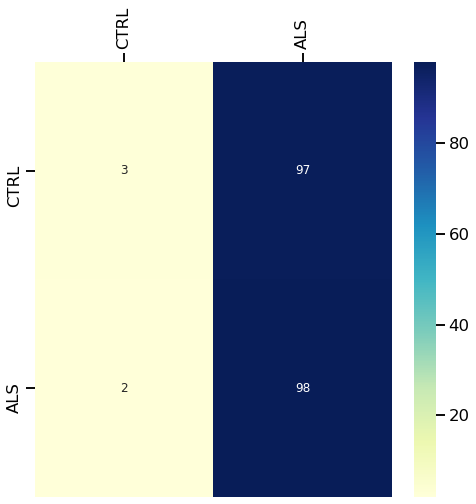

In [48]:
# Plot confusion matrix
sns.set_context("talk", rc={"font":"Helvetica", "font.size":12})
label = ["CTRL", "ALS"]
cm = confusion_matrix(Y, y_hat, labels=[0, 1])
plt.figure(figsize=(8, 8))
cm = 100 * cm / cm.sum(axis=1)[:,np.newaxis]
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='0.0f',
                 xticklabels=label, yticklabels=label)
ax.xaxis.tick_top()
plt.xticks(rotation=90) 
plt.show()

## Test on Fine-tuning (useless but worth mentionning)

In [49]:
from training import run_epoch
from torch import optim
from sklearn.model_selection import GroupKFold

### Train/val

In [50]:
n_splits=8

In [51]:
group_kfold = GroupKFold(n_splits=n_splits)
group_kfold.get_n_splits(X, Y, groups)
list_accuracy = []
for train_index, test_index in group_kfold.split(X, Y, groups):
    #load the model
    cnn, _, _ = load_model()
    # Fine-tune CNN
    epochs = 1 # Change this number to ~30 for full training
    batch_size = 10
    t0 = time()
    # Set up Adam optimizer
    optimizer = optim.Adam(cnn.parameters(), lr=1e-3, betas=(0.5, 0.999))
    # Set up dataloaders
    dl_tr = spectral_dataloader(X, Y, idxs=train_index,
        batch_size=batch_size, shuffle=True)
    dl_val = spectral_dataloader(X, Y, idxs=test_index,
        batch_size=batch_size, shuffle=False)
    # Fine-tune CNN for first fold
    best_val = 0
    no_improvement = 0
    max_no_improvement = 5
    print('Starting fine-tuning!')
    for epoch in range(epochs):
        print(' Epoch {}: {:0.2f}s'.format(epoch+1, time()-t0))
        # Train
        acc_tr, loss_tr = run_epoch(epoch, cnn, dl_tr, cuda,
            training=True, optimizer=optimizer)
        print('  Train acc: {:0.2f}'.format(acc_tr))
        # Val
        acc_val, loss_val = run_epoch(epoch, cnn, dl_val, cuda,
            training=False, optimizer=optimizer)
        print('  Val acc  : {:0.2f}'.format(acc_val))
        # Check performance for early stopping
        if acc_val > best_val or epoch == 0:
            best_val = acc_val
            no_improvement = 0
        else:
            no_improvement += 1
        if no_improvement >= max_no_improvement:
            print('Finished after {} epochs!'.format(epoch+1))
            break

    list_accuracy.append(acc_val)
    
print('\n This demo was completed in: {:0.2f}s'.format(time()-t00))
print(mean(list_accuracy))

key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 90.21
  Val acc  : 98.57
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 87.88
  Val acc  : 97.18
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 91.03
  Val acc  : 88.46
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 88.69
  Val acc  : 83.33
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 89.21
  Val acc  : 100.00
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 88.82
  Val acc  : 100.00
key: linear.weight is removed
key: linear.bias is removed
Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 89.02
  Val acc  : 94.44
key: linear.weight is removed
key: linear.bias is removed
St